In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

In [9]:
def plot_roc_curve(test, model_probs, naive_probs):
    fpr, tpr, _ = roc_curve(test, naive_probs)
    plt.plot(fpr, tpr, linestyle = '--', label = 'Baseline')
    fpr, tpr, _ = roc_curve(test, model_probs)
    plt.plot(fpr, tpr, marker = '.', label = 'Neural Network', markersize = 0.1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')
    plt.show()
    
def plot_pr_curve(test, model_probs):
    no_skill = len(test[test == 1]) / len(test)
    
    plt.plot( [no_skill, no_skill], linestyle = '--', label = 'Baseline')
    
    precision, recall, _ = precision_recall_curve(test, model_probs)
    plt.plot(recall, precision, marker = '.', label = 'Neural Network', markersize = 0.1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision - Recall Curve')
    plt.legend()
    plt.show()

In [3]:
df = pd.read_csv('./data/loan_rf_features.csv')

In [68]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'total_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'avg_cur_bal', 'pub_rec_bankruptcies', 'tax_liens',
       'mort_acc', 'credit_file_age', 'fico', 'log_annual_inc'],
      dtype='object')

In [65]:
df.shape

(1319510, 23)

In [4]:
X = pd.get_dummies(df.drop(columns = ['loan_status']))
y = df['loan_status']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size= 0.2)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

n_input = X_train.shape[1]


In [17]:
model = Sequential()

model.add(Dense(32, input_dim = n_input, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

opt = SGD(learning_rate = 0.001)

model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])

In [18]:
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 15,
                    batch_size = 256,
                    verbose = 1)

Epoch 1/15
4124/4124 [==============================] - 5s 1ms/step - loss: 0.4904 - recall: 0.0441 - precision: 0.2027 - prc: 0.2316 - accuracy: 0.7756 - val_loss: 0.4199 - val_recall: 0.0071 - val_precision: 0.9144 - val_prc: 0.2944 - val_accuracy: 0.8026
Epoch 2/15
4124/4124 [==============================] - 4s 1ms/step - loss: 0.3760 - recall: 0.1782 - precision: 0.8248 - prc: 0.3625 - accuracy: 0.8292 - val_loss: 0.3366 - val_recall: 0.3680 - val_precision: 0.7950 - val_prc: 0.4426 - val_accuracy: 0.8556
Epoch 3/15
4124/4124 [==============================] - 4s 1ms/step - loss: 0.3044 - recall: 0.4936 - precision: 0.7778 - prc: 0.5103 - accuracy: 0.8713 - val_loss: 0.2816 - val_recall: 0.5869 - val_precision: 0.7696 - val_prc: 0.5650 - val_accuracy: 0.8830
Epoch 4/15
4124/4124 [==============================] - 4s 994us/step - loss: 0.2666 - recall: 0.6376 - precision: 0.7657 - prc: 0.6002 - accuracy: 0.8892 - val_loss: 0.2590 - val_recall: 0.6747 - val_precision: 0.7604 - val_p

In [19]:
def plot_history(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    train_prc = history.history['prc']
    test_prc = history.history['val_prc']
    
    plt.figure(figsize = (12, 8))
    plt.plot(train_loss, label = 'Training Loss', color = 'purple')
    plt.plot(test_loss, label = 'Testing Loss', color = 'lavender')
    plt.plot(train_acc, label = 'Training Accuracy', color = 'navy')
    plt.plot(test_acc, label = 'Testing Accuracy', color = 'skyblue')
    plt.plot(train_prc, label = 'Training PRC Score', color = 'green')
    plt.plot(test_prc, label = 'Testing PRC Score', color = 'lightgreen')
    plt.legend()
    plt.show();

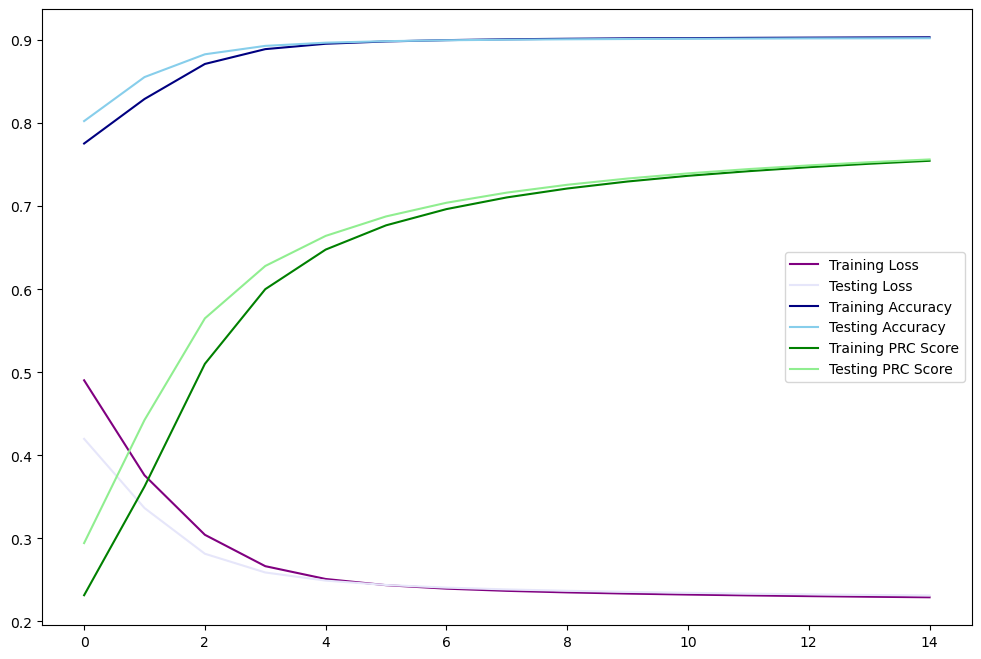

In [20]:
plot_history(history)

In [26]:
nn_train_preds = model.predict(X_train)
nn_test_preds = model.predict(X_test)

C:\Users\eddie\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [32]:
accuracy_score(y_test, nn_test_preds.round())

0.902342536244515

In [33]:
dummy_model = DummyClassifier(strategy= 'stratified')
dummy_model.fit(X_train, y_train)
naive_preds = dummy_model.predict(X_test)

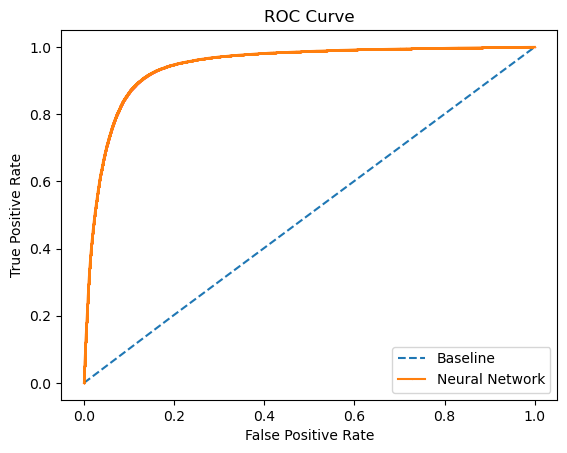

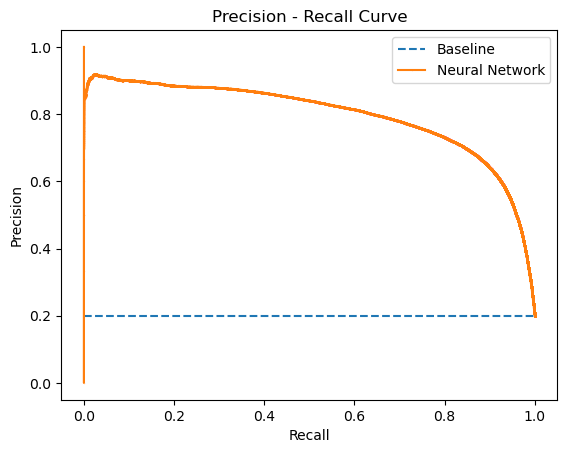

Testing Data ROC-AUC score KNN (Best Parameters + Feature Selection): 0.945
Testing Data PR-AUC score KNN (GridSearch CV): 0.797


In [34]:
plot_roc_curve(y_test, nn_test_preds, naive_preds)
plot_pr_curve(y_test, nn_test_preds)
print(f'Testing Data ROC-AUC score neural network: {roc_auc_score(y_test, nn_test_preds):.3f}')
precision, recall, _ = precision_recall_curve(y_test, nn_test_preds)
print(f'Testing Data PR-AUC score KNN (GridSearch CV): {auc(recall, precision):.3f}')

In [38]:
model2 = Sequential()

model2.add(Dense(24, input_dim = n_input, activation = 'relu'))
model2.add(Dense(12, activation = 'relu'))
model2.add(Dense(12, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

opt = SGD(learning_rate = 0.001)
model2.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [ keras.metrics.AUC(name='prc', curve='PR'), 'Precision', 'Recall'])

In [39]:
history = model2.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 30,
                    verbose = 2,
                    batch_size = 256,
                    class_weight = {1 : 0.8, 0 : 0.2})

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
4124/4124 - 5s - loss: 0.2249 - prc: 0.1931 - precision: 0.2036 - recall: 0.6870 - val_loss: 0.6932 - val_prc: 0.2039 - val_precision: 0.2238 - val_recall: 0.5080
Epoch 2/30
4124/4124 - 4s - loss: 0.2186 - prc: 0.2114 - precision: 0.2439 - recall: 0.4738 - val_loss: 0.6676 - val_prc: 0.2192 - val_precision: 0.2649 - val_recall: 0.4768
Epoch 3/30
4124/4124 - 4s - loss: 0.2148 - prc: 0.2268 - precision: 0.2825 - recall: 0.5057 - val_loss: 0.6554 - val_prc: 0.2356 - val_precision: 0.2984 - val_recall: 0.5468
Epoch 4/30
4124/4124 - 4s - loss: 0.2096 - prc: 0.2451 - precision: 0.3149 - recall: 0.5833 - val_loss: 0.6388 - val_prc: 0.2563 - val_precision: 0.3311 - val_recall: 0.6248
Epoch 5/30
4124/4124 - 4s - loss: 0.2015 - prc: 0.2691 - precision: 0.3488 - recall: 0.6575 - val_loss: 0.6120 - val_prc: 0.2846 - val_precision: 0.3688 - val_recall:

In [58]:
X.columns.shape

(44,)

In [99]:
plot_history(history)

KeyError: 'auc'

In [135]:
model3 = Sequential()

model3.add(Dense(24, input_dim = n_input, activation = 'relu'))
model3.add(Dense(12, activation = 'relu', kernel_regularizer = l2(0.001)))
model3.add(Dense(6, activation = 'relu', kernel_regularizer = l2(0.001)))
model3.add(Dense(1, activation = 'sigmoid'))

opt = SGD(learning_rate = 0.001)
model3.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])

In [136]:
history3 = model3.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 30,
                    verbose = 2,
                    batch_size = 256,
                    class_weight = {1 : 0.8, 0 : 0.2})

Epoch 1/30
4124/4124 - 6s - loss: 0.2485 - recall: 0.8259 - precision: 0.1909 - prc: 0.1899 - accuracy: 0.2697 - val_loss: 0.7583 - val_recall: 0.7692 - val_precision: 0.2024 - val_prc: 0.2105 - val_accuracy: 0.3519
Epoch 2/30
4124/4124 - 5s - loss: 0.2379 - recall: 0.7629 - precision: 0.2356 - prc: 0.2326 - accuracy: 0.4610 - val_loss: 0.7317 - val_recall: 0.7833 - val_precision: 0.2826 - val_prc: 0.2618 - val_accuracy: 0.5619
Epoch 3/30
4124/4124 - 5s - loss: 0.2266 - recall: 0.8081 - precision: 0.3114 - prc: 0.2926 - accuracy: 0.6068 - val_loss: 0.7069 - val_recall: 0.8294 - val_precision: 0.3359 - val_prc: 0.3256 - val_accuracy: 0.6402
Epoch 4/30
4124/4124 - 5s - loss: 0.2147 - recall: 0.8352 - precision: 0.3565 - prc: 0.3560 - accuracy: 0.6677 - val_loss: 0.6741 - val_recall: 0.8401 - val_precision: 0.3804 - val_prc: 0.3856 - val_accuracy: 0.6963
Epoch 5/30
4124/4124 - 5s - loss: 0.2025 - recall: 0.8408 - precision: 0.4027 - prc: 0.4115 - accuracy: 0.7205 - val_loss: 0.6360 - val_

In [112]:
df[df['loan_status'] == 1]

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,...,pub_rec,revol_bal,revol_util,avg_cur_bal,pub_rec_bankruptcies,tax_liens,mort_acc,credit_file_age,fico,log_annual_inc
9,18000.0,1,19.48,471.70,5-10 years,RENT,1,debt_consolidation,9.39,0.0,...,1.0,14052.0,40.7,2014.0,1.0,0.0,2.0,10,582.0,11.918391
20,4225.0,0,14.85,146.16,1-5 years,RENT,1,debt_consolidation,15.22,2.0,...,0.0,1058.0,24.6,815.0,0.0,0.0,0.0,4,249.5,10.463103
25,16000.0,0,12.88,538.18,10+ years,MORTGAGE,1,small_business,18.96,0.0,...,1.0,5157.0,54.3,5683.0,0.0,1.0,0.0,30,627.0,11.082143
26,24250.0,1,24.24,701.01,1-5 years,MORTGAGE,1,debt_consolidation,20.84,0.0,...,0.0,24799.0,65.3,17783.0,0.0,0.0,2.0,8,249.5,11.225243
28,25000.0,1,13.99,581.58,5-10 years,MORTGAGE,1,debt_consolidation,34.53,0.0,...,0.0,22519.0,18.6,8556.0,0.0,0.0,6.0,14,602.0,11.277203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319497,32000.0,1,13.99,744.42,10+ years,MORTGAGE,1,debt_consolidation,29.89,1.0,...,0.0,44852.0,41.6,29071.0,0.0,0.0,7.0,21,537.0,11.736069
1319500,11200.0,1,13.49,257.66,1-5 years,RENT,1,debt_consolidation,4.80,0.0,...,2.0,12581.0,54.7,1797.0,0.0,2.0,0.0,22,249.5,11.362103
1319503,36400.0,1,14.49,856.24,1-5 years,RENT,1,credit_card,21.50,0.0,...,0.0,55723.0,79.8,43772.0,0.0,0.0,6.0,29,552.0,11.461632
1319507,32000.0,1,14.49,752.74,1-5 years,MORTGAGE,1,home_improvement,10.34,0.0,...,0.0,111598.0,27.4,29193.0,0.0,0.0,3.0,5,249.5,11.964001


In [147]:
model4 = Sequential()

model4.add(Dense(24, input_dim = n_input, activation = 'relu'))
model4.add(Dense(12, activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(12, activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation = 'sigmoid'))

opt = SGD(learning_rate = 0.001)
model4.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])

In [148]:
history4 = model4.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 50,
                    verbose = 2,
                    batch_size = 128,
                    )

Epoch 1/50
8247/8247 - 10s - loss: 0.4985 - recall: 0.0089 - precision: 0.2242 - prc: 0.2349 - accuracy: 0.7969 - val_loss: 0.4337 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_prc: 0.2713 - val_accuracy: 0.8013
Epoch 2/50
8247/8247 - 9s - loss: 0.4188 - recall: 0.0154 - precision: 0.7039 - prc: 0.3111 - accuracy: 0.8030 - val_loss: 0.3542 - val_recall: 0.0524 - val_precision: 0.8019 - val_prc: 0.3686 - val_accuracy: 0.8091
Epoch 3/50
8247/8247 - 8s - loss: 0.3404 - recall: 0.3064 - precision: 0.7566 - prc: 0.4376 - accuracy: 0.8426 - val_loss: 0.2740 - val_recall: 0.5936 - val_precision: 0.7825 - val_prc: 0.5027 - val_accuracy: 0.8864
Epoch 4/50
8247/8247 - 9s - loss: 0.2923 - recall: 0.5730 - precision: 0.7430 - prc: 0.5455 - accuracy: 0.8757 - val_loss: 0.2502 - val_recall: 0.7177 - val_precision: 0.7580 - val_prc: 0.5789 - val_accuracy: 0.8984
Epoch 5/50
8247/8247 - 8s - loss: 0.2744 - recall: 0.6555 - precision: 0.7383 - prc: 0.6031 - accuracy: 0.8854 - val_loss: 0.24

In [150]:
model5 = Sequential()

model5.add(Dense(24, input_dim = n_input, activation = 'relu'))
model5.add(Dense(12, activation = 'relu', kernel_regularizer = l2(0.001)))
model5.add(Dropout(0.1))
model5.add(Dense(12, activation = 'relu', kernel_regularizer = l2(0.001)))
model5.add(Dropout(0.1))
model5.add(Dense(1, activation = 'sigmoid'))

opt = SGD(learning_rate = 0.001)
model5.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])

In [151]:
history5 = model5.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 50,
                    verbose = 2,
                    batch_size = 128,
                    )

Epoch 1/50
8247/8247 - 10s - loss: 0.5290 - recall: 0.0121 - precision: 0.1615 - prc: 0.1992 - accuracy: 0.7912 - val_loss: 0.4506 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_prc: 0.2541 - val_accuracy: 0.8013
Epoch 2/50
8247/8247 - 9s - loss: 0.4197 - recall: 0.0057 - precision: 0.5883 - prc: 0.3128 - accuracy: 0.8016 - val_loss: 0.3597 - val_recall: 0.0252 - val_precision: 0.8132 - val_prc: 0.3853 - val_accuracy: 0.8051
Epoch 3/50
8247/8247 - 9s - loss: 0.3431 - recall: 0.3757 - precision: 0.7550 - prc: 0.4564 - accuracy: 0.8517 - val_loss: 0.2954 - val_recall: 0.6807 - val_precision: 0.7565 - val_prc: 0.5236 - val_accuracy: 0.8930
Epoch 4/50
8247/8247 - 8s - loss: 0.2990 - recall: 0.7154 - precision: 0.7278 - prc: 0.5660 - accuracy: 0.8903 - val_loss: 0.2721 - val_recall: 0.7688 - val_precision: 0.7330 - val_prc: 0.5977 - val_accuracy: 0.8984
Epoch 5/50
8247/8247 - 8s - loss: 0.2838 - recall: 0.7652 - precision: 0.7220 - prc: 0.6202 - accuracy: 0.8948 - val_loss: 0.26

In [43]:
def model_deep(hidden_neurons, hidden_layers, dropout):
    model = Sequential()
    for layer in range(hidden_layers):
        if layer == 0:
            model.add(Dense(hidden_neurons, activation = 'relu', input_dim = n_input))
            model.add(Dropout(dropout))
        else:
            model.add(Dense(hidden_neurons / 2, activation = 'relu'))
            model.add(Dropout(dropout))
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'bce', optimizer = 'adam', metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])
    
    return model
    
params_deep = {
    'hidden_neurons' : [24, 32],
    'hidden_layers'  : [2, 3],
    'dropout'        : [0.1, 0.2, 0.5],
    'epochs'         : [30],
}

nn = KerasClassifier(build_fn = model_deep, batch_size = 512)

gs_deep = GridSearchCV(estimator = nn, param_grid = params_deep, cv = 3, verbose = 1)
gs_deep.fit(X_train, y_train, validation_data = (X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Epoch 1/30
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2690 - recall: 0.6712 - precision: 0.7434 - prc: 0.6530 - accuracy: 0.8884 - val_loss: 0.2271 - val_recall: 0.7839 - val_precision: 0.7464 - val_prc: 0.7645 - val_accuracy: 0.9041
Epoch 2/30
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2300 - recall: 0.7832 - precision: 0.7479 - prc: 0.7788 - accuracy: 0.9042 - val_loss: 0.2243 - val_recall: 0.7999 - val_precision: 0.7420 - val_prc: 0.7869 - val_accuracy: 0.9050
Epoch 3/30
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2270 - recall: 0.7806 - precision: 0.7530 - prc: 0.7919 - accuracy: 0.9053 - val_loss: 0.2230 - val_recall: 0.7823 - val_precision: 0.7523 - val_prc: 0.7952 - val_accuracy: 0.9056
Epoch 4/30
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2256 - recall: 0.7749 - precision: 0.7566 - prc: 0.7978 - accuracy: 0.9055 - val_loss: 

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001D47B9F3E50>,
             param_grid={'dropout': [0.1, 0.2, 0.5], 'epochs': [30],
                         'hidden_layers': [2, 3], 'hidden_neurons': [24, 32]},
             verbose=1)

In [56]:
gs_deep.best_params_

{'dropout': 0.1, 'epochs': 30, 'hidden_layers': 2, 'hidden_neurons': 32}

In [44]:
gs_deep.score(X_test, y_test)

516/516 [==============================] - 1s 1ms/step - loss: 0.2197 - recall: 0.7672 - precision: 0.7628 - prc: 0.8182 - accuracy: 0.9063


0.9063288569450378

In [45]:
gs_deep.score(X_train, y_train)

2062/2062 [==============================] - 3s 1ms/step - loss: 0.2164 - recall: 0.7696 - precision: 0.7656 - prc: 0.8183 - accuracy: 0.9074


0.9073765873908997

In [50]:
deep_train_probs = gs_deep.predict_proba(X_train)[:,1]
deep_test_probs = gs_deep.predict_proba(X_test)[:,1]
deep_train_preds = gs_deep.predict(X_train)
deep_test_preds = gs_deep.predict(X_test)


C:\Users\eddie\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [52]:
precision_score(y_test, deep_test_preds)

0.7627822328385372

In [54]:
recall_score(y_test, deep_test_preds)

0.7672329958240375

In [61]:
best_model = Sequential()

best_model.add(Dense(32, activation = 'relu', input_dim = n_input))
best_model.add(Dropout(0.1))
best_model.add(Dense(16, activation = 'relu'))
best_model.add(Dropout(0.1))
best_model.add(Dense(1, activation = 'sigmoid'))

best_model.compile(loss = 'bce', optimizer = 'adam', metrics = [ 'Recall', 'Precision',  keras.metrics.AUC(name='prc', curve='PR'), 'accuracy'])

best_history = best_model.fit(X_train, y_train,
                              validation_data = (X_test, y_test),
                              epochs = 30,
                              batch_size = 512,
                              verbose = 1)

Epoch 1/30
2062/2062 [==============================] - 5s 2ms/step - loss: 0.2552 - recall: 0.7044 - precision: 0.7383 - prc: 0.6746 - accuracy: 0.8916 - val_loss: 0.2239 - val_recall: 0.7930 - val_precision: 0.7437 - val_prc: 0.7763 - val_accuracy: 0.9046
Epoch 2/30
2062/2062 [==============================] - 4s 2ms/step - loss: 0.2258 - recall: 0.7852 - precision: 0.7479 - prc: 0.7875 - accuracy: 0.9047 - val_loss: 0.2227 - val_recall: 0.7989 - val_precision: 0.7418 - val_prc: 0.7943 - val_accuracy: 0.9048
Epoch 3/30
2062/2062 [==============================] - 4s 2ms/step - loss: 0.2237 - recall: 0.7800 - precision: 0.7531 - prc: 0.7981 - accuracy: 0.9055 - val_loss: 0.2214 - val_recall: 0.7737 - val_precision: 0.7569 - val_prc: 0.8011 - val_accuracy: 0.9056
Epoch 4/30
2062/2062 [==============================] - 4s 2ms/step - loss: 0.2226 - recall: 0.7761 - precision: 0.7563 - prc: 0.8033 - accuracy: 0.9058 - val_loss: 0.2210 - val_recall: 0.7728 - val_precision: 0.7579 - val_prc

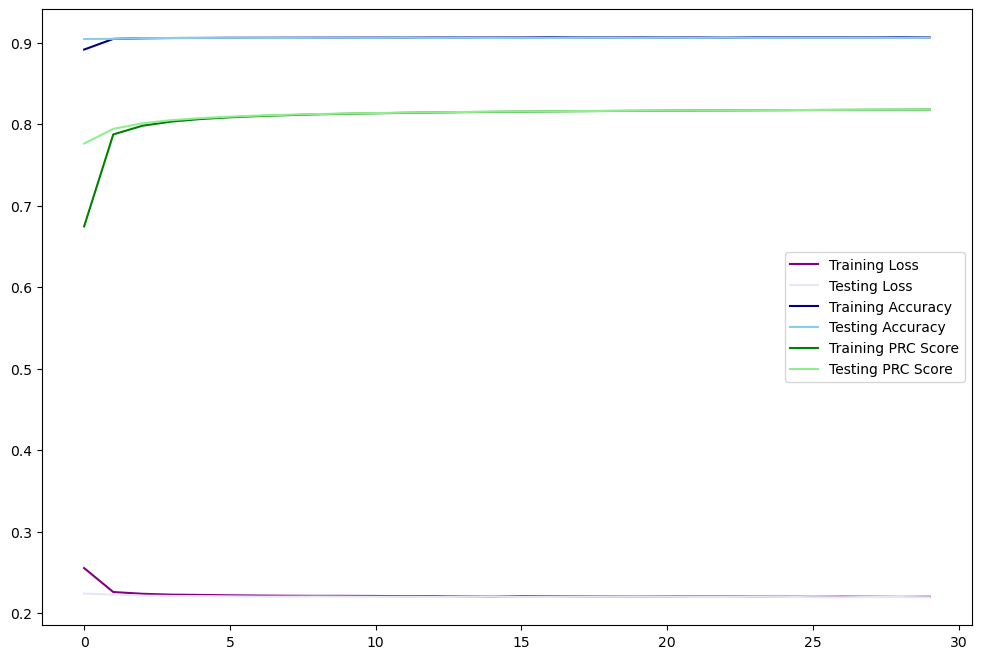

In [62]:
plot_history(best_history)